In [135]:
from matplotlib import pyplot as plt
from Levenshtein import distance
import pandas as pd
import numpy as np
import unicodedata

import itertools
import os

In [30]:
DATA_PATH = os.path.join('..', 'data')
RAW_PATH = os.path.join(DATA_PATH, 'raw')
INTERMEDIATE_PATH = os.path.join(DATA_PATH, 'intermediate')

In [31]:
def get_levenstein_dataframe(series, threshold=3):
    uniques = sorted(series.unique())
    if len(uniques) == 1:
        return pd.DataFrame(columns=['a', 'b', 'distance'])
    levenstein = pd.DataFrame(
        itertools.combinations(uniques, 2),
        columns=['a', 'b']
    )
    levenstein['sorted'] = levenstein.apply(lambda x: tuple(sorted([x['a'], x['b']])), axis=1)
    levenstein = levenstein.drop_duplicates(subset='sorted').drop(columns='sorted')
    levenstein['distance'] = levenstein.apply(lambda x: distance(x['a'], x['b']), axis=1)
    return (
        levenstein
        .query('0 < distance < @threshold')
        .sort_values(['distance', 'a', 'b'])
        .reset_index(drop=True)
    )

In [50]:
dfs = list()
for eleccion in [2013, 2017, 2021]:
    for tipo in ['1ra', '2da']:
        df = pd.read_parquet(
            os.path.join(INTERMEDIATE_PATH, f'pres-{eleccion}-{tipo}.parquet')
        )
        df.insert(0, 'eleccion', eleccion)
        df.insert(1, 'tipo', tipo[0])
        dfs.append(df)
df_new = pd.concat(dfs)
object_cols = df_new.select_dtypes(include=['object']).columns
# df_new[object_cols] = df_new[object_cols].astype('category')
df_new[['eleccion', 'tipo']] = df_new[['eleccion', 'tipo']].astype('int')
df_new.reset_index(drop=True, inplace=True)
df_new = df_new.groupby(['eleccion', 'tipo', 'region', 'electoral', 'candidato']).votos.sum().reset_index()
# df_new.drop(columns=['senatorial', 'distrito', 'comuna', 'local', 'mesa'], inplace=True)
df_new

,eleccion,tipo,region,electoral,candidato,votos
0,2013,1,ANTOFAGASTA,ANTOFAGASTA NORTE,ALFREDO SFEIR,431
1,2013,1,ANTOFAGASTA,ANTOFAGASTA NORTE,EVELYN MATTHEI,7320
2,2013,1,ANTOFAGASTA,ANTOFAGASTA NORTE,FRANCO ALDO PARISI,10249
3,2013,1,ANTOFAGASTA,ANTOFAGASTA NORTE,MARCEL CLAUDE,1196
4,2013,1,ANTOFAGASTA,ANTOFAGASTA NORTE,MARCO ENRIQUEZ-OMINAMI,6569
...,...,...,...,...,...,...
26192,2021,2,ÑUBLE,VEGAS DE ITATA,VOTOS NULOS,4
26193,2021,2,ÑUBLE,YUNGAY,GABRIEL BORIC,3458
26194,2021,2,ÑUBLE,YUNGAY,JOSE ANTONIO KAST,3693
26195,2021,2,ÑUBLE,YUNGAY,VOTOS EN BLANCO,25


In [93]:
df_old = pd.read_parquet(os.path.join(INTERMEDIATE_PATH, 'pres-1990-2014.parquet'))
df_old = df_old.query('eleccion != 2014')
df_old.drop(columns=['porcentaje'], inplace=True)
replace_region = {
    'RIOS': 'LOS RIOS',
    'LAGOS': 'LOS LAGOS',
}
df_old.region = df_old.region.str.upper().replace(replace_region)#.astype('category')
replace_electoral = {
    'AISEN': 'AYSEN',
    'PELCHUQUAAN': 'PELCHUQUIN',
    'CURRINAA': 'CURRINE',
}
df_old.electoral = (
    df_old.electoral
    .str.normalize('NFKD')
    .str.encode('ascii', errors='ignore')
    .str.decode('utf-8')
    .str.replace("O'HIGGINS", 'OHIGGINS', regex=False)
    .str.replace(r'\s+', ' ', regex=True)
    .str.replace(r'\((.*?)\)', r'\1', regex=True)
    .str.replace(r'-\s*([^\-]+?)\s*-', r'\1', regex=True)
    .str.replace(r'\s*-\s*', ' - ', regex=True)
    .replace(replace_electoral)
    .str.strip()
    # .astype('category')
)
df_old.candidato = df_old.candidato.str.upper()
df_old

,eleccion,tipo,region,electoral,candidato,votos
0,1990,0,TARAPACA,ARICA,FRANCISCO J. ERRÁZURIZ,14981
1,1990,0,TARAPACA,ARICA,HERNÁN BÜCHI,25786
2,1990,0,TARAPACA,ARICA,PATRICIO AYLWIN,44556
3,1990,0,TARAPACA,BELEN,FRANCISCO J. ERRÁZURIZ,81
4,1990,0,TARAPACA,BELEN,HERNÁN BÜCHI,143
...,...,...,...,...,...,...
15110,2010,2,MAGALLANES,SAN GREGORIO,SEBASTIÁN PIÑERA,253
15111,2010,2,MAGALLANES,TIMAUKEL,EDUARDO FREI,111
15112,2010,2,MAGALLANES,TIMAUKEL,SEBASTIÁN PIÑERA,106
15113,2010,2,MAGALLANES,TORRES DEL PAINE C. CASTILLO,EDUARDO FREI,345


In [94]:
df_old.value_counts(['eleccion', 'tipo']).sort_index()

eleccion  tipo
1990      0       1407
1994      0       2934
2000      1       3054
          2       1018
2006      1       2212
          2       1106
2010      1       2256
          2       1128
Name: count, dtype: int64

In [107]:
df = pd.concat([df_old, df_new])
df.region = df.region.replace('AISEN', 'AYSEN')
df.candidato = df.candidato.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df

,eleccion,tipo,region,electoral,candidato,votos
0,1990,0,TARAPACA,ARICA,FRANCISCO J. ERRAZURIZ,14981
1,1990,0,TARAPACA,ARICA,HERNAN BUCHI,25786
2,1990,0,TARAPACA,ARICA,PATRICIO AYLWIN,44556
3,1990,0,TARAPACA,BELEN,FRANCISCO J. ERRAZURIZ,81
4,1990,0,TARAPACA,BELEN,HERNAN BUCHI,143
...,...,...,...,...,...,...
26192,2021,2,ÑUBLE,VEGAS DE ITATA,VOTOS NULOS,4
26193,2021,2,ÑUBLE,YUNGAY,GABRIEL BORIC,3458
26194,2021,2,ÑUBLE,YUNGAY,JOSE ANTONIO KAST,3693
26195,2021,2,ÑUBLE,YUNGAY,VOTOS EN BLANCO,25


In [191]:
include_zeros = True
soft = 1

bellwethers = dict()
soft_bellwethers = dict()
years = df.query('tipo < 2' if include_zeros else 'tipo == 1').eleccion.unique() 
for year in years:
    if include_zeros:
        bellwether = df.query('eleccion <= @year and tipo < 2')
    else:
        bellwether = df.query('eleccion <= @year and tipo == 1')
    bellwether = bellwether.sort_values(['eleccion', 'region', 'electoral', 'votos'], ascending=[True, True, True, False])
    bellwether = bellwether.drop_duplicates(subset=['eleccion', 'region', 'electoral'], keep='first')
    bellwether = bellwether[
        ((bellwether.eleccion == 1990) & (bellwether.candidato == 'PATRICIO AYLWIN')) |
        ((bellwether.eleccion == 1994) & (bellwether.candidato == 'EDUARDO FREI')) |
        ((bellwether.eleccion == 2000) & (bellwether.candidato == 'RICARDO LAGOS')) |
        ((bellwether.eleccion == 2006) & (bellwether.candidato == 'MICHELLE BACHELET')) |
        ((bellwether.eleccion == 2010) & (bellwether.candidato == 'SEBASTIAN PINERA')) |
        ((bellwether.eleccion == 2013) & (bellwether.candidato == 'MICHELLE BACHELET')) |
        ((bellwether.eleccion == 2017) & (bellwether.candidato == 'SEBASTIAN PINERA')) |
        ((bellwether.eleccion == 2021) & (bellwether.candidato == 'JOSE ANTONIO KAST'))
    ]
    vc = bellwether.value_counts(['region', 'electoral'])
    total_elections = bellwether.eleccion.nunique()
    n_bellwether = (vc == total_elections).sum()
    n_soft_bellwether = (vc >= max(1, total_elections-soft)).sum()
    bellwethers[year] = n_bellwether
    soft_bellwethers[year] = n_soft_bellwether
    print(f'{year}: n_bellwether={n_bellwether}, n_soft_bellwether={n_soft_bellwether}')

1990: n_bellwether=386, n_soft_bellwether=386
1994: n_bellwether=383, n_soft_bellwether=456
2000: n_bellwether=199, n_soft_bellwether=389
2006: n_bellwether=198, n_soft_bellwether=373
2010: n_bellwether=109, n_soft_bellwether=336
2013: n_bellwether=109, n_soft_bellwether=329
2017: n_bellwether=81, n_soft_bellwether=294
2021: n_bellwether=30, n_soft_bellwether=214


In [184]:
save = vc[vc == total_elections].reset_index()
total_counts = df.groupby(['eleccion', 'tipo', 'region', 'electoral']).votos.sum().reset_index()
counts = total_counts[
    total_counts.region.isin(save.region) &
    total_counts.electoral.isin(save.electoral)
].copy()
counts.groupby(['eleccion', 'tipo']).votos.sum()/total_counts.groupby(['eleccion', 'tipo']).votos.sum()

eleccion  tipo
1990      0       0.225640
1994      0       0.226053
2000      1       0.224893
          2       0.223332
2006      1       0.217874
          2       0.216487
2010      1       0.212968
          2       0.210849
2013      1       0.210032
          2       0.207531
2017      1       0.209857
          2       0.207732
2021      1       0.203061
          2       0.206937
Name: votos, dtype: float64

In [185]:
df.query('electoral == "MAIPU"').sort_values(['eleccion', 'tipo', 'votos'], ascending=[False, False, False]).drop_duplicates(subset=['eleccion', 'tipo'], keep='first').query('tipo < 2')

,eleccion,tipo,region,electoral,candidato,votos
21693,2021,1,METROPOLITANA,MAIPU,GABRIEL BORIC,38632
13377,2017,1,METROPOLITANA,MAIPU,SEBASTIAN PINERA,35461
4746,2013,1,METROPOLITANA,MAIPU,MICHELLE BACHELET,46913
12394,2010,1,METROPOLITANA,MAIPU,SEBASTIAN PINERA,48729
9064,2006,1,METROPOLITANA,MAIPU,MICHELLE BACHELET,59053
5233,2000,1,METROPOLITANA,MAIPU,RICARDO LAGOS,59252
2282,1994,0,METROPOLITANA,MAIPU,EDUARDO FREI,61353
437,1990,0,METROPOLITANA,MAIPU,PATRICIO AYLWIN,54467


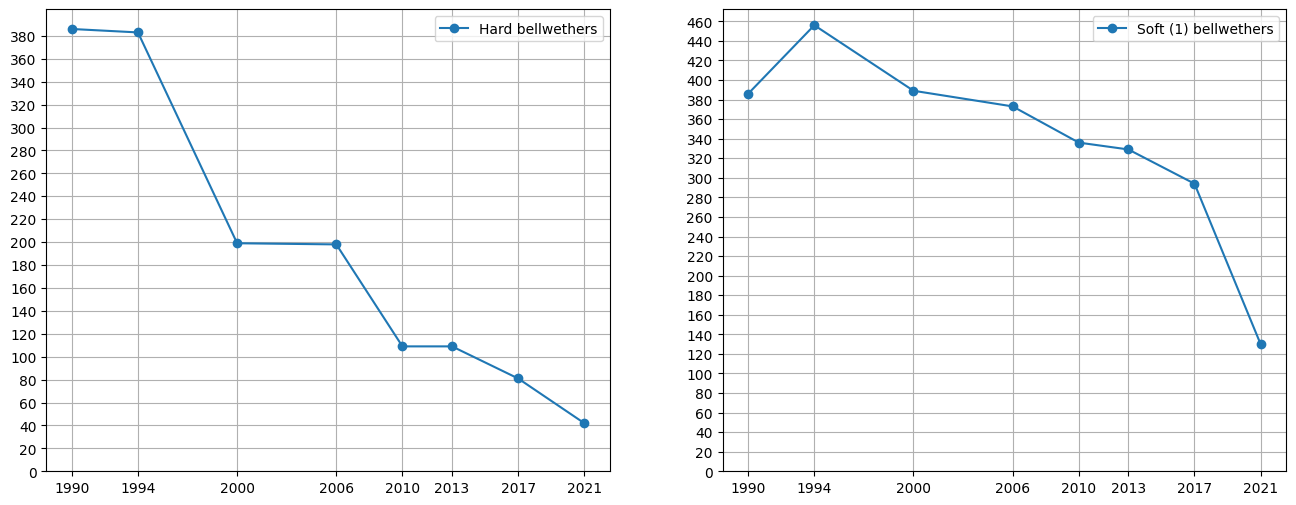

In [186]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].plot(list(bellwethers.keys()), list(bellwethers.values()), marker='o', label='Hard bellwethers')
ax[0].set_xticks(list(bellwethers.keys()))
ax[0].set_yticks(np.arange(0, max(bellwethers.values())+10, 20))
ax[0].grid()
ax[0].legend()
ax[1].plot(list(soft_bellwethers.keys()), list(soft_bellwethers.values()), marker='o', label=f'Soft ({soft}) bellwethers')
ax[1].set_xticks(list(soft_bellwethers.keys()))
ax[1].set_yticks(np.arange(0, max(soft_bellwethers.values())+10, 20))
ax[1].grid()
ax[1].legend()
plt.show()

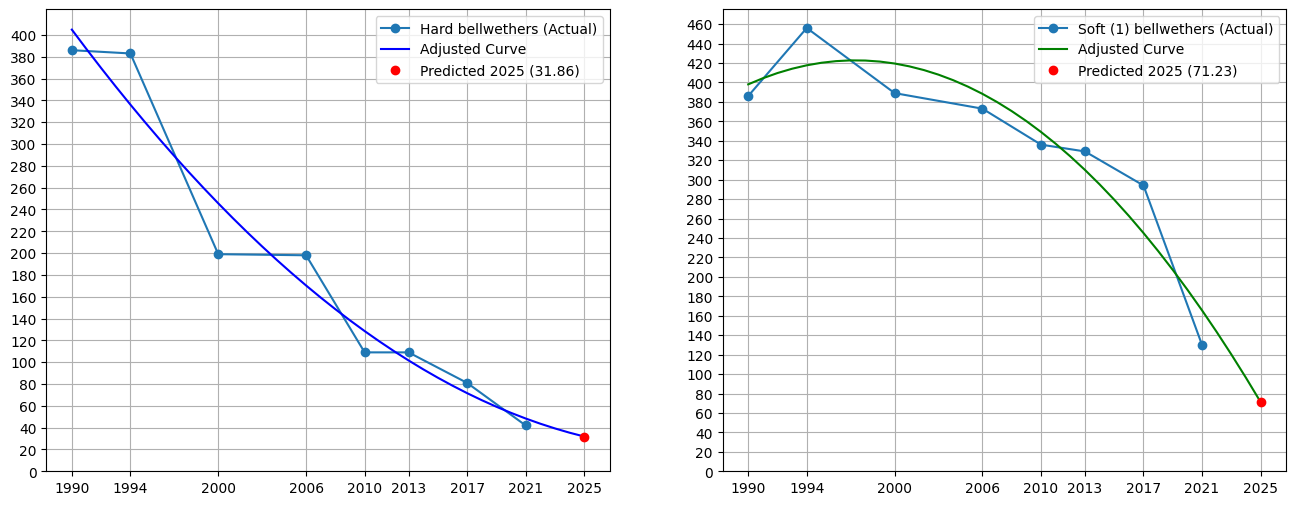

In [188]:
years = np.array(list(bellwethers.keys()))
hard_bellwether_counts = np.array(list(bellwethers.values()))

soft_years = np.array(list(soft_bellwethers.keys()))
soft_bellwether_counts = np.array(list(soft_bellwethers.values()))

# Fit a polynomial curve to the data
degree = 2  # Quadratic fit
hard_coeffs = np.polyfit(years, hard_bellwether_counts, degree)
soft_coeffs = np.polyfit(soft_years, soft_bellwether_counts, degree)

# Create polynomial functions
hard_poly = np.poly1d(hard_coeffs)
soft_poly = np.poly1d(soft_coeffs)

# Generate adjusted curves including 2025
future_years = np.arange(min(years), 2026, 1)
hard_curve = hard_poly(future_years)
soft_curve = soft_poly(future_years)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Hard bellwethers
ax[0].plot(years, hard_bellwether_counts, 'o-', label='Hard bellwethers (Actual)')
ax[0].plot(future_years, hard_curve, 'b-', label='Adjusted Curve')
ax[0].plot(2025, hard_poly(2025), 'ro', label=f'Predicted 2025 ({hard_poly(2025):.2f})')
ax[0].set_xticks(np.append(years, 2025))
ax[0].set_yticks(np.arange(0, max(hard_bellwether_counts) + 20, 20))
ax[0].grid()
ax[0].legend()

# Soft bellwethers
ax[1].plot(soft_years, soft_bellwether_counts, 'o-', label=f'Soft ({soft}) bellwethers (Actual)')
ax[1].plot(future_years, soft_curve, 'g-', label='Adjusted Curve')
ax[1].plot(2025, soft_poly(2025), 'ro', label=f'Predicted 2025 ({soft_poly(2025):.2f})')
ax[1].set_xticks(np.append(soft_years, 2025))
ax[1].set_yticks(np.arange(0, max(soft_bellwether_counts) + 20, 20))
ax[1].grid()
ax[1].legend()

plt.show()